# Data pre-processing

This notebook cleans and structure textual data. We use a sample data generated based on sklearn available dataset of “Twenty Newsgroups”. This is only a small set to run the notebooks with, and not suitable for generating results. For more information about this dataset, please see: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

#### Input:

article_sample.csv: 

This dataset contains all the articles. It is structured in 3 columns: An article ID, an article, and a publication date.

#### Output:

The code will produce a dataset saved in a file `ws2_1_article_clean.csv`. The dataset is structured in 6 columns: an article ID, an article (original text), a number of words (in the article), a cleaned version of the text, the number of words (in the cleaned text), and a publication date.

#### How do we clean the text of the articles?

From every article, we remove:
- The white spaces at the beginning and at the end of the text
- The HTML tags
- All the special characters, i.e. all characters that are not a digit nor an alphabetical letter
- All the punctuations
- All the english stop-words
- All the words that are not an adjective, a noun, or an adverb.

Then we use lemmatization to turn every word to its base or dictionary form.

We also plot the histograms of the number of words before and after the cleaning process, and filter on the article length for noise reduction.
    

### Include all the dependencies

In [ ]:
import re
import nltk
import pandas as pd
import numpy as np
import os
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_colwidth = 50

### Configuration parameters

In [22]:
# The path to the output folder where all the outputs will be saved
output_path = "/project_data/data_asset"

### Define the utility functions

In [23]:
def clean(text):
    """ Removes from the input text:
        - html tags, 
        - punctuations, 
        - stop words,
        - words of less than 3 characters
        - all words that are not a noun, an adjective, or a verb.

    Arguments:
        text (str) :
            The text to be cleaned

    Raises:
        TypeError: if input parameters are not of the expected type

    Returns:
        text (str) :
            The cleaned text (lowercased)
    """
    
    if not isinstance(text, str):
        raise TypeError("Argument 'text' must be a string.")
    
    # Strip the text, lowercase it, and remove the HTML tags and punctuations
    text = text.lower().strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^ 0-9a-z]', ' ', text)
    text = re.sub(r'\b(\d+\d)\b', '', text)
    text = re.sub(r'http|https|www', '', text)
    text = re.sub(r'\b[a-z]\b', '', text)
    text = re.sub(r' +', ' ', text)
    text = text.translate(text.maketrans('', '', string.punctuation)) #extra punctuations removal

    # Remove all the stop words
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend([
        'from', 're', 'also'
    ])
    stop_words = {key: True for key in set(stop_words)}
    
    # Keep only specific pos (part of speech: nouns, adjectives, and adverbs)
    keep_pos = {key: True for key in ['NN','NNS','NNP','NNPS', 'JJ', 'JJR', 'JJS','RB','RBR','RBS']}
    
    return " ".join([word 
                     for word, pos in nltk.tag.pos_tag(text.split()) 
                     if len(word) > 2 and word not in stop_words and pos in keep_pos])

In [24]:
def lemmatize(text: str, lemmatizer: nltk.stem.WordNetLemmatizer) -> str:
    """ Lemmatize the words in a sentence by:
        - mapping the POS tag to each word,
        - lemmatize the word.

    Arguments:
        sentence (str):
            The sentence in which the words need to be lemmatized
        lemmatizer:
            Lemmatizer function

   Raises:
        TypeError: if input parameters are not of the expected type

    Returns:
        Lemmatized text
    ----------------------------------------------------------------------------------------
    """
    
    if not isinstance(text, str):
        raise TypeError("Argument 'text' must be a string.")

    lemmas = []
    tag_dict = {
        "J": nltk.corpus.wordnet.ADJ,
        "N": nltk.corpus.wordnet.NOUN,
        "V": nltk.corpus.wordnet.VERB,
        "R": nltk.corpus.wordnet.ADV
    }
    
    tokenized_words = nltk.word_tokenize(text)
    for tokenized_word in tokenized_words:
        tag = nltk.tag.pos_tag([tokenized_word])[0][1][0].upper() # Map POS tag to first character lemmatize() accepts
        wordnet_pos = tag_dict.get(tag, nltk.corpus.wordnet.NOUN)
        lemma = lemmatizer.lemmatize(tokenized_word, wordnet_pos)
        lemmas.append(lemma)
    
    return " ".join(lemmas)

### Load the input dataset

In [25]:
articles = pd.read_csv(f"{output_path}/article_sample.csv")

print(f"Number of records: {len(articles)}")

articles.head()

Number of records: 151


,article_id,article,date
0,0,an acquaintance in Post-Polio >Syndrome This a...,2020-01-01
1,1,"homore in high school. Before that, I used to ...",2020-01-02
2,2,"7:26 GMT On 5 Apr 93 23:27:26 GMT, (Vida Morku...",2020-01-03
3,3,tes about heat shock proteins (HSP's) and DNA....,2020-01-04
4,4,now mapping the human genome. We will > then s...,2020-01-05


### Analyse the number of words per article

In [26]:
articles["n_words"] = articles["article"].apply(lambda text: len(text.split(" ")))

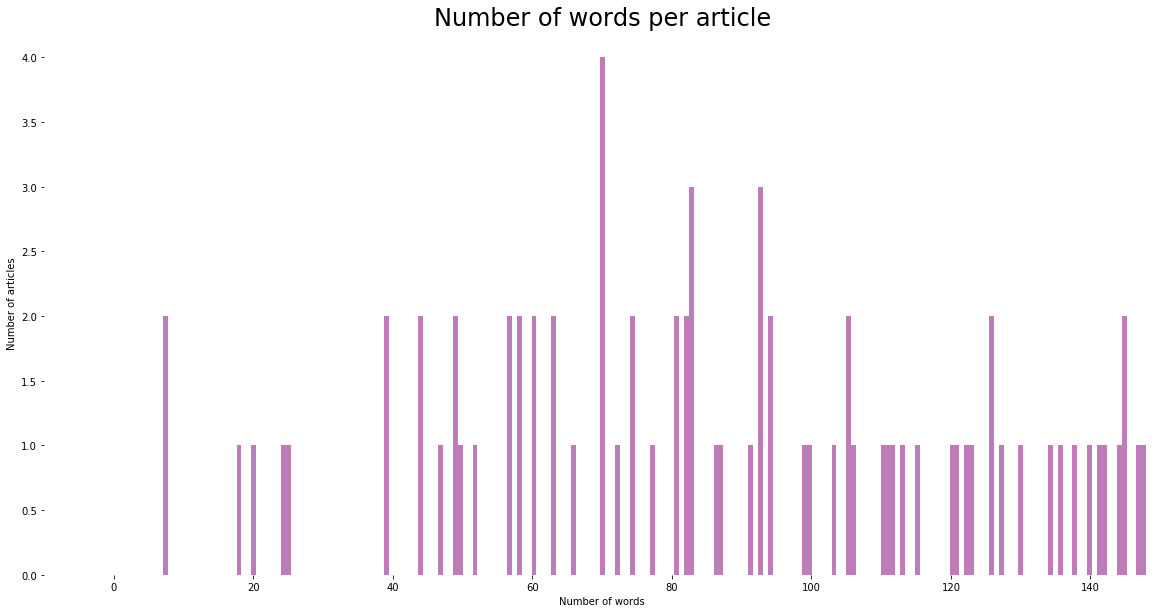

In [27]:
import matplotlib.pyplot as plt

# clean article word count
plt.figure(figsize=(20, 10))
plt.hist(articles[articles["n_words"] < 150].n_words, bins = 200, color = ["#bf7cbb"])
plt.gca().set(xlim=(-10, 150), ylabel='Number of articles', xlabel='Number of words')
plt.box(False)
plt.title('Number of words per article', fontdict=dict(size=24))
plt.show()

In [28]:
# Keep only the articles that contain more than 50 words

articles = articles[articles["n_words"] > 50]

### Clean the articles

In [29]:
articles["article_clean"] = articles["article"].apply(clean)

lemmatizer = nltk.stem.WordNetLemmatizer()
articles["article_clean"] = articles["article_clean"].apply(lambda x: lemmatize(x, lemmatizer)) 

articles["n_words_clean"] = articles["article_clean"].apply(lambda x: len(x.split(" ")))

articles.head()

,article_id,article,date,n_words,article_clean,n_words_clean
0,0,an acquaintance in Post-Polio >Syndrome This a...,2020-01-01,160,acquaintance post polio syndrome apparently ne...,64
1,1,"homore in high school. Before that, I used to ...",2020-01-02,81,homore high school bloody nose nighttime asthm...,26
2,2,"7:26 GMT On 5 Apr 93 23:27:26 GMT, (Vida Morku...",2020-01-03,280,gmt apr gmt vida morkunas vida inner ear probl...,123
3,3,tes about heat shock proteins (HSP's) and DNA....,2020-01-04,159,te heat shock protein hsp dna hate derogatory ...,55
4,4,now mapping the human genome. We will > then s...,2020-01-05,290,human genome manipulation genome genetic engin...,119


### Analyse the number of words per clean article

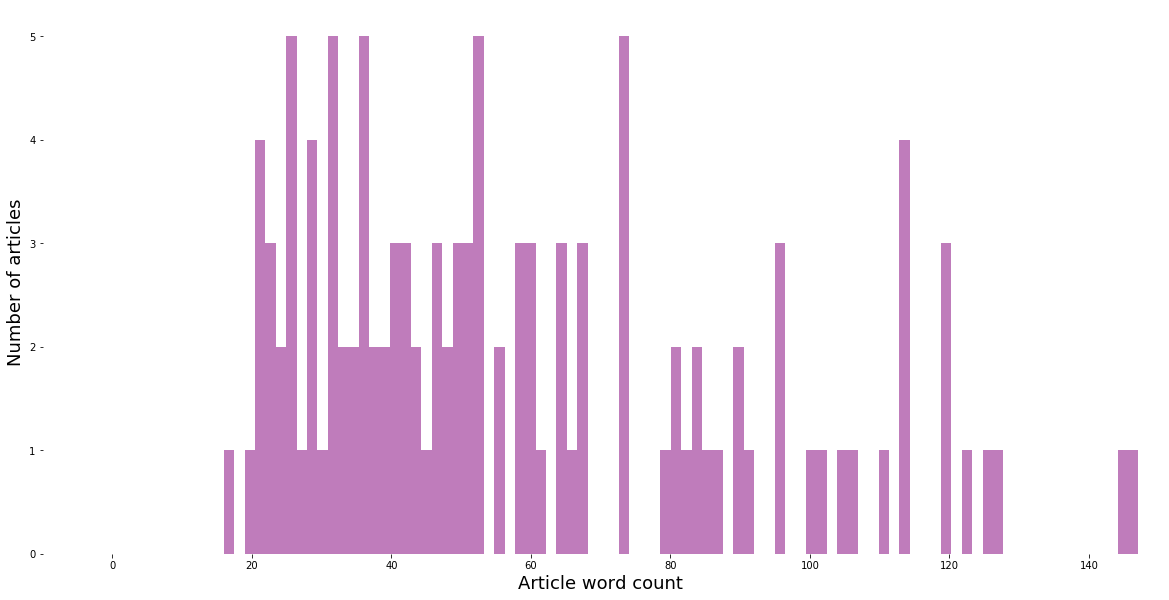

In [30]:
import matplotlib.pyplot as plt

# clean article word count
plt.figure(figsize=(20, 10))
plt.hist(articles[articles["n_words_clean"] < 400].n_words_clean, 
         bins = 200, 
         color = ["#bf7cbb"])
plt.xlim((-10, 150))
plt.xlabel("Article word count", fontsize=18)
plt.ylabel("Number of articles", fontsize=18)
plt.box(False)
plt.show()

### Save the output

In [31]:
articles.to_csv(f"{output_path}/ws2_1_article_clean.csv", index=False)

#### Authors
    
* **Mehrnoosh Vahdat** is Data Scientist with Data Science & AI Elite team where she specializes in Data Science, Analytics platforms, and Machine Learning solutions.
* **Vincent Nelis** is Senior Data Scientist with Data Science & AI Elite team where he specializes in Data Science, Analytics platforms, and Machine Learning solutions.

Copyright © IBM Corp. 2020. Licensed under the Apache License, Version 2.0. Released as licensed Sample Materials.